In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from logistic import logistic_regression
from model_eval import model_eval
%matplotlib inline 

/home/ubuntu/anaconda2/lib/python2.7/site-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [2]:
train_data = pd.read_csv('train.csv', delimiter=',')
test_data = pd.read_csv('test.csv', delimiter=',')

In [2]:
'''
Pre-processing and normalize the data

Data visualization to explore relationship between features

'''

'\nPre-processing and normalize the data\n\nData visualization to explore relationship between features\n\n'

In [7]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [17]:
surv = train_data[train_data['Survived']==1]
nosurv = train_data[train_data['Survived']==0]
surv_col = "blue"
nosurv_col = "red"

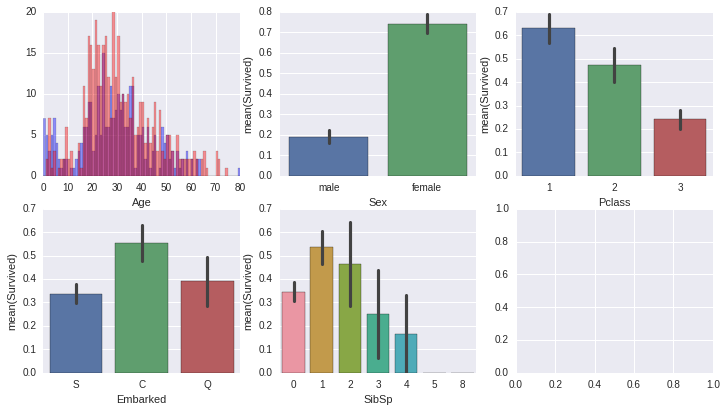

In [23]:
#Data distribution (mean and variance of the data)
plt.figure(figsize=[12,10])
plt.subplot(331)
sns.distplot(surv['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color=surv_col)
sns.distplot(nosurv['Age'].dropna().values, bins=range(0, 81, 1), kde=False, color=nosurv_col, axlabel='Age')
plt.subplot(332)
sns.barplot('Sex', 'Survived', data=train_data)
plt.subplot(333)
sns.barplot('Pclass', 'Survived', data=train_data)
plt.subplot(334)
sns.barplot('Embarked', 'Survived', data=train_data)
plt.subplot(335)
sns.barplot('SibSp', 'Survived', data=train_data)
plt.subplot(336)

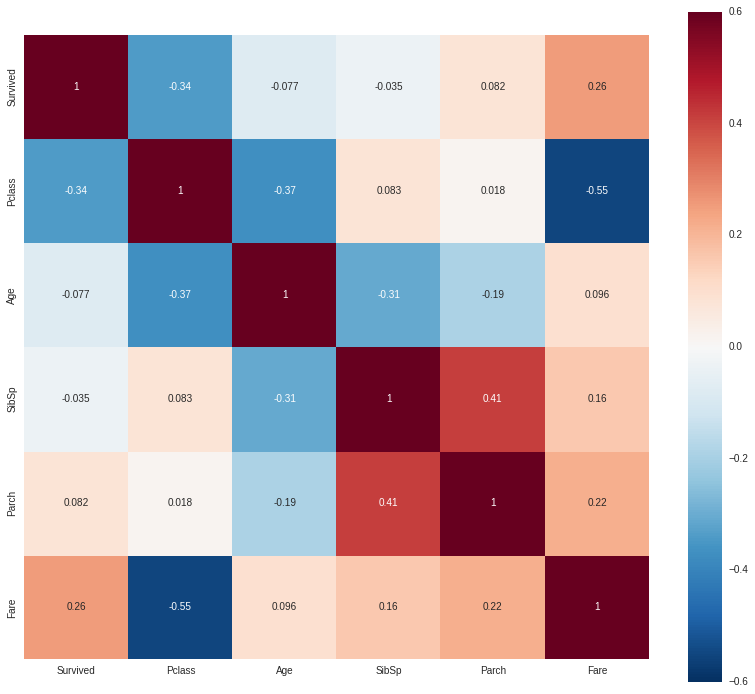

In [25]:
#Compute correlation matrix
plt.figure(figsize=(14,12))
heat = sns.heatmap(train_data.drop('PassengerId',axis=1).corr(), vmax=0.6, square=True, annot=True)

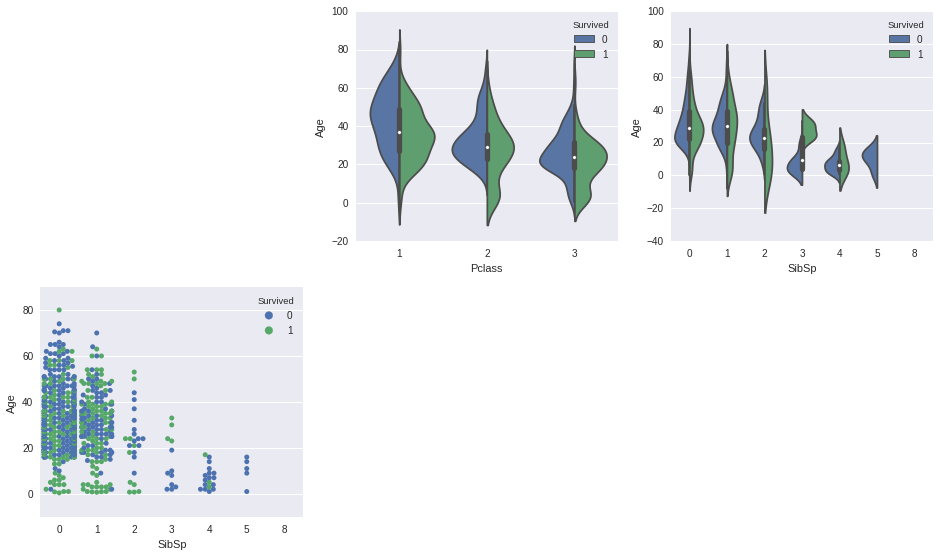

In [38]:
plt.figure(figsize=[16,14])
plt.subplot(335)
sns.violinplot(x="Pclass", y="Age", hue="Survived", data=train_data, split=True)
plt.subplot(336)
sns.violinplot(x="SibSp", y="Age", hue="Survived", data=train_data, split=True)
plt.subplot(337)
sns.swarmplot(x="SibSp", y="Age", hue="Survived", data=train_data)

In [21]:
clean_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_n,Embarked_C,Embarked_Q,Embarked_S,Survived
0,3,1,22.0,1,0,7.2500,0,0,0,0,0,0,0,0,1,0,0,1,0
1,1,0,38.0,1,0,71.2833,0,0,1,0,0,0,0,0,0,1,0,0,1
2,3,0,26.0,0,0,7.9250,0,0,0,0,0,0,0,0,1,0,0,1,1
3,1,0,35.0,1,0,53.1000,0,0,1,0,0,0,0,0,0,0,0,1,1
4,3,1,35.0,0,0,8.0500,0,0,0,0,0,0,0,0,1,0,0,1,0


In [4]:
'''
Turning catagory value using 1 hot and convert binary to 0/1 value
Inital experiement, dropping name and ticket where it makes linear regression easier
The cluster analysis should include such features to increase information gain
''' 
def clean_linear_reg (train_data):
    temp = train_data.copy()
    #Features to modify or drop
    temp.loc[:,'Cabin'] = temp['Cabin'].apply(lambda x : str(x)[:1])
    temp.loc[:, 'Sex'] = temp['Sex'].apply(lambda x: 1 if x == "male" else 0)
    temp = temp.drop(['Name','Ticket', 'PassengerId'], 1)
    #temp = temp.drop('Ticket',1,)
    #temp = temp.drop('PassengerId', 1)
    #Apply one hot encoding for categorical data to analysis
    temp = pd.get_dummies(temp)
    #exclusive for titanic data
    temp['Age'].fillna(temp['Age'].mean(), inplace=True)
    cols = temp.columns.tolist()
    cols.pop(0)
    cols.append('Survived')
    temp = temp[cols]
    return temp

def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

def split_data(data, percent):
    train_size = len(data) * percent * 0.01
    train_size = int(train_size)
    return data.iloc[:train_size, :], data.iloc[train_size:, :]

In [5]:
clean_data = clean_linear_reg(train_data)
norm_data= normalize(clean_data)
clean_train_norm, clean_test_norm = split_data(norm_data,80)
#clean_train_norm = normalize(clean_data[0])
#clean_test_norm = normalize(clean_data[1])

In [39]:
print clean_train_norm.shape
print clean_test_norm.shape

(712, 19)
(179, 19)


In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn import svm
from sklearn import neural_network

In [41]:
model = LogisticRegression()
model.fit(clean_train_norm.iloc[:,:-1], clean_train_norm.iloc[:,-1])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [42]:
model.score(clean_test_norm.iloc[:,:-1], clean_test_norm.iloc[:,-1])

0.82122905027932958

In [43]:
model = logistic_regression()
Y = clean_train_norm.iloc[:,-1]
X = clean_train_norm.iloc[:,:-1]
model.fit(X,Y)

In [44]:
temp = model_eval(logistic_regression())

In [45]:
temp.k_cross_validation(3,X,Y)

237


0.810126582278481

The logistic regression performs well with basic classification after normalization and conversion to numeric value.
The NA value is filled by the mean of the column. The performance of the model does not seem to be affect by the number of missing data. Logsitic model is good at handling noises

In [46]:
#Decision tree classifier
decision_tree_classifer = tree.DecisionTreeClassifier()
decision_tree_classifer.fit(clean_train_norm.iloc[:,:-1], clean_train_norm.iloc[:,-1])
decision_tree_classifer.score(clean_test_norm.iloc[:,:-1], clean_test_norm.iloc[:,-1])

0.82681564245810057

In [47]:
#K-Nearest neighbor
knn_classifer = KNeighborsClassifier(n_neighbors=3)
knn_classifer.fit(clean_train_norm.iloc[:,:-1], clean_train_norm.iloc[:,-1])
knn_classifer.score(clean_test_norm.iloc[:,:-1], clean_test_norm.iloc[:,-1])

0.83798882681564246

In [48]:
#Support Vector machine
svm_classifer = svm.SVC(C=100)
svm_classifer.fit(clean_train_norm.iloc[:,:-1], clean_train_norm.iloc[:,-1])
svm_classifer.score(clean_test_norm.iloc[:,:-1], clean_test_norm.iloc[:,-1])

0.84357541899441346

In [49]:
ann_classifer = neural_network.MLPClassifier(hidden_layer_sizes=5, alpha=0.001, learning_rate='adaptive')
ann_classifer.fit(clean_train_norm.iloc[:,:-1], clean_train_norm.iloc[:,-1])
ann_classifer.score(clean_test_norm.iloc[:,:-1], clean_test_norm.iloc[:,-1])

0.81564245810055869